# ==========================================================
# 📊 ANALYSE DE SURVIE des machines (Kaplan-Meier) - 
# Auteur : Kossi NOUMAGNO
## Objectif principal : Estimer la probabilité de survie des machines industrielles en fonction des infos telemetriques.
## Objectifs secondaires:
### 1-Identifier les modèles de machines les plus fiables et
### 2-les facteurs qui influencent sur la performance d`une machine 
# ==========================================================


# MAIN Programm

Aperçu des données :
   machineID   model  age  time  event        volt      rotate    pressure  \
0          1  model3   18   4.0      1  170.833898  446.336502  100.668306   
1          2  model4    7  77.0      1  170.760482  446.388915  100.539930   
2          3  model3    8   6.0      1  170.659235  446.583238  100.653114   
3          4  model3    7  16.0      1  170.659728  446.053801  100.569902   
4          5  model3    2   8.0      1  171.044435  446.858577  101.066188   

   vibration  error_count  maint_count  
0  40.586309           35           37  
1  40.301539           28           32  
2  40.475376           39           37  
3  40.341620           31           33  
4  40.264846           38           35   


Résumé statistique :
        machineID         age       time       event        volt      rotate  \
count  100.000000  100.000000  100.00000  100.000000  100.000000  100.000000   
mean    50.500000   11.330000   35.47875    0.980000  170.777736  446.605119   


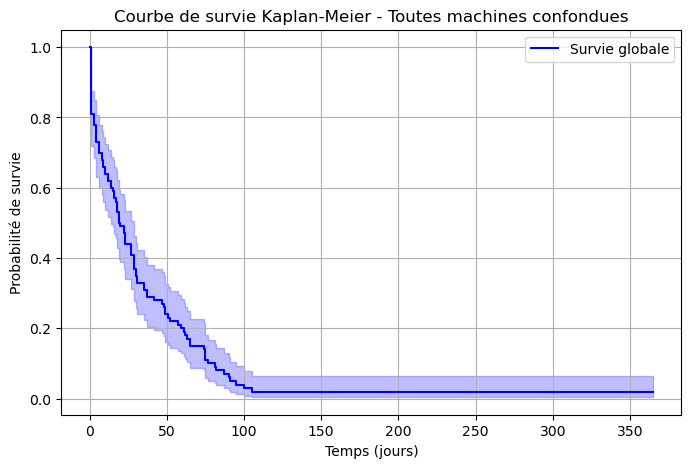


Espérance de survie moyenne : 19.0


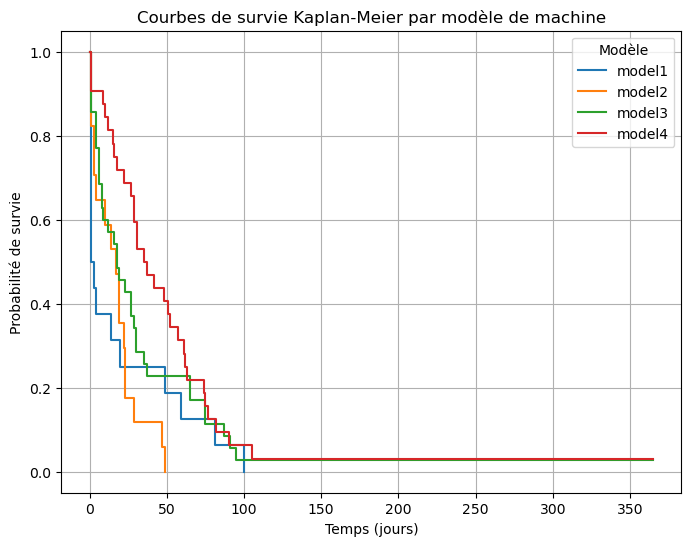

In [1]:
# --- Importation des bibliothèques ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# --- Chargement des données ---
file_path = "Predictive_Table.csv"   # chemin du fichier
data = pd.read_csv(file_path)

# --- Aperçu initial ---
print("Aperçu des données :")
print(data.head(), "\n")
print()
print("Résumé statistique :")
print(data.describe(), "\n")

# ==========================================================
#  Courbe de survie globale Kaplan-Meier
# ==========================================================

kmf = KaplanMeierFitter()
T = data["time"]
E = data["event"]

plt.figure(figsize=(8, 5))
kmf.fit(T, event_observed=E, label="Survie globale")
kmf.plot_survival_function(ci_show=True, color="blue")
plt.title("Courbe de survie Kaplan-Meier - Toutes machines confondues")
plt.xlabel("Temps (jours)")
plt.ylabel("Probabilité de survie")
plt.grid(True)
plt.show()
print()

print("Espérance de survie moyenne :", round(kmf.median_survival_time_, 2))

# ==========================================================
# Comparaison des modèles de machine
# ==========================================================

plt.figure(figsize=(8, 6))
for model, subset in data.groupby("model"):
    kmf.fit(subset["time"], subset["event"], label=f"{model}")
    kmf.plot_survival_function(ci_show=False)

plt.title("Courbes de survie Kaplan-Meier par modèle de machine")
plt.xlabel("Temps (jours)")
plt.ylabel("Probabilité de survie")
plt.legend(title="Modèle")
plt.grid(True)
plt.show()

# ==========================================================
# Influence du nombre de maintenances
# ==========================================================

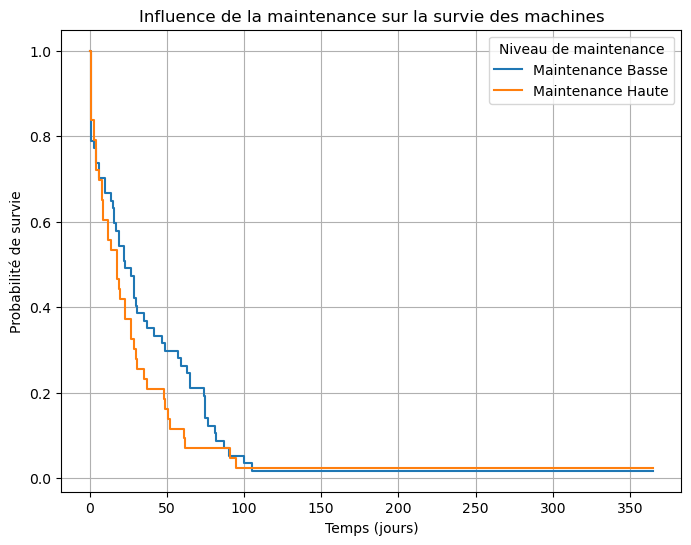

In [2]:
# Segmentation en 2 groupes : peu entretenues vs très entretenues
median_maint = data["maint_count"].median()
data["maintenance_group"] = np.where(data["maint_count"] > median_maint, "Haute", "Basse")

plt.figure(figsize=(8, 6))
for group, subset in data.groupby("maintenance_group"):
    kmf.fit(subset["time"], subset["event"], label=f"Maintenance {group}")
    kmf.plot_survival_function(ci_show=False)

plt.title("Influence de la maintenance sur la survie des machines")
plt.xlabel("Temps (jours)")
plt.ylabel("Probabilité de survie")
plt.legend(title="Niveau de maintenance")
plt.grid(True)
plt.show()

# Test statistique
res_maint = logrank_test(
    data.loc[data["maintenance_group"] == "Haute", "time"],
    data.loc[data["maintenance_group"] == "Basse", "time"],
    event_observed_A=data.loc[data["maintenance_group"] == "Haute", "event"],
    event_observed_B=data.loc[data["maintenance_group"] == "Basse", "event"]
)

# ==========================================================
# Influence de l'âge des machines
# ==========================================================

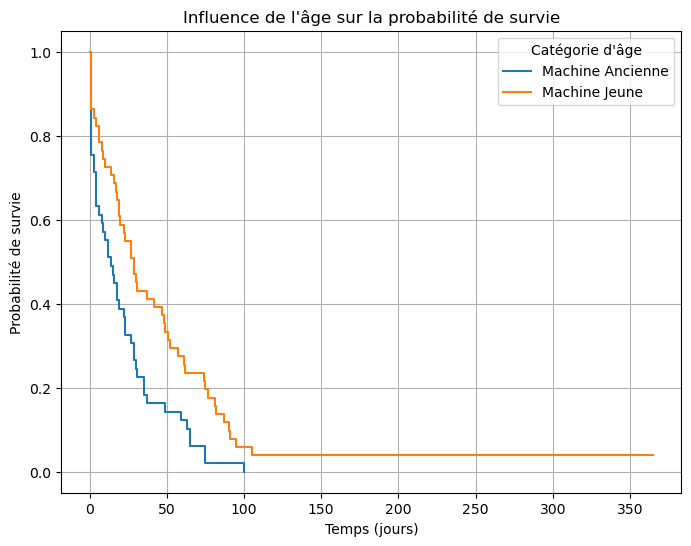

In [3]:
# Création de groupes d'âge (jeunes vs anciennes)
median_age = data["age"].median()
data["age_group"] = np.where(data["age"] > median_age, "Ancienne", "Jeune")

plt.figure(figsize=(8, 6))
for group, subset in data.groupby("age_group"):
    kmf.fit(subset["time"], subset["event"], label=f"Machine {group}")
    kmf.plot_survival_function(ci_show=False)

plt.title("Influence de l'âge sur la probabilité de survie")
plt.xlabel("Temps (jours)")
plt.ylabel("Probabilité de survie")
plt.legend(title="Catégorie d'âge")
plt.grid(True)
plt.show()

# Test statistique
res_age = logrank_test(
    data.loc[data["age_group"] == "Ancienne", "time"],
    data.loc[data["age_group"] == "Jeune", "time"],
    event_observed_A=data.loc[data["age_group"] == "Ancienne", "event"],
    event_observed_B=data.loc[data["age_group"] == "Jeune", "event"]
)

# ==========================================================
# Analyse descriptive complémentaire
# ==========================================================

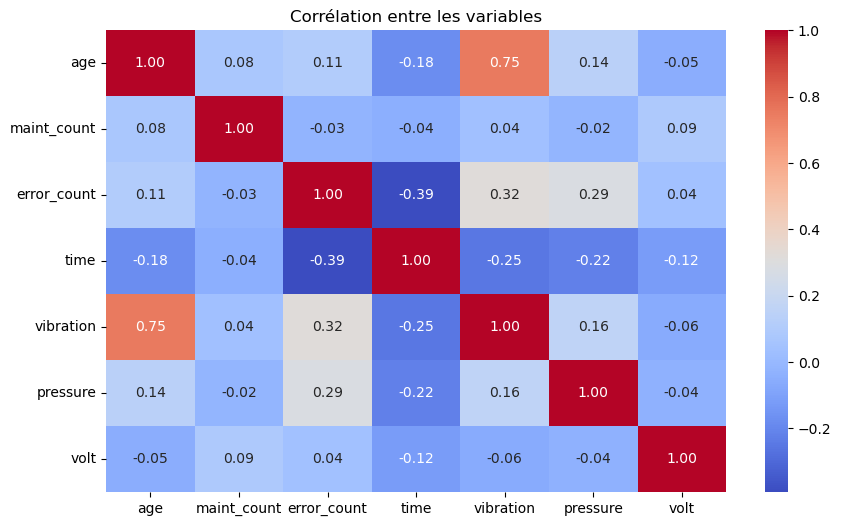

In [4]:
# Corrélation des variables quantitatives
plt.figure(figsize=(10, 6))
sns.heatmap(data[["age", "maint_count", "error_count", "time", "vibration", "pressure", "volt"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation entre les variables")
plt.show()

# Information importante:
### Une forte vibration est plus liee a l`age de la machine

# ==========================================================
# 🧭 7️⃣ Conclusion analytique
# ==========================================================

### Les machines des modèles avec courbes plus abruptes présentent plus de pannes précoces.
### La maintenance préventive a un effet positif net sur la durée de vie.
### Les machines anciennes montrent une survie réduite (usure naturelle).
### La variable 'error_count' et l`age peuvent être utilisées comme indicateur de risque.